#############################################################################################################################################

################################################### Importing necessary libraries

#############################################################################################################################################

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import skew

#############################################################################################################################################

####################################################### Function Definitions

#############################################################################################################################################

In [7]:

############################ 1. Data Processing functions #######################################
def dataframe_info_and_null_percentage(data):
    """
    Prints DataFrame information and calculates the percentage of null values in each column.

    Parameters:
    - data: pd.DataFrame - The DataFrame to analyze.

    Returns:
    - null_percentage: pd.Series - Series with the percentage of null values for each column.
    """
    # Display information about the DataFrame
    print("DataFrame Information:")
    data.info()
    print("\n")

    # Calculate the percentage of null values in each column
    null_percentage = (data.isnull().sum() / len(data)) * 100

    # Print the result
    print("Percentage of Null Values in Each Column:")
    
    
    return null_percentage


def find_missing_columns(data, column_type='all'):
    """
    Identifies columns with missing values based on the specified type of columns.

    Parameters:
    - data: pd.DataFrame - The DataFrame containing the data.
    - column_type: str - The type of columns to check ('numerical', 'categorical', or 'all').

    Returns:
    - missing_columns: list - List of column names with missing values based on the selected type.
    """
    if column_type == 'numerical':
        # Select numerical columns
        numerical_columns = data.select_dtypes(include=['number'])
        # Identify numerical columns with missing values
        missing_columns = numerical_columns.columns[numerical_columns.isnull().any()].tolist()
    
    elif column_type == 'categorical':
        # Select categorical columns
        categorical_columns = data.select_dtypes(include=['category', 'object'])
        # Identify categorical columns with missing values
        missing_columns = categorical_columns.columns[categorical_columns.isnull().any()].tolist()
    
    elif column_type == 'all':
        # Select numerical and categorical columns
        numerical_columns = data.select_dtypes(include=['number'])
        categorical_columns = data.select_dtypes(include=['category', 'object'])
        
        # Identify columns with missing values
        numerical_missing_columns = numerical_columns.columns[numerical_columns.isnull().any()].tolist()
        categorical_missing_columns = categorical_columns.columns[categorical_columns.isnull().any()].tolist()
        
        # Combine and remove duplicates
        missing_columns = list(set(numerical_missing_columns + categorical_missing_columns))
    
    else:
        raise ValueError("Invalid column_type. Use 'numerical', 'categorical', or 'all'.")
    
    return missing_columns

def plot_histogram_and_check_distribution(data, value_column, bins=10, title=None, xlabel=None, ylabel='Frequency'):
    """
    Plots a histogram of a specified numerical column from a DataFrame and checks if the distribution is skewed or normal.

    Parameters:
    - data: pd.DataFrame - The DataFrame containing the data.
    - value_column: str - The name of the numerical column to plot the histogram for.
    - bins: int - The number of bins for the histogram (default is 10).
    - title: str - The title of the histogram (optional).
    - xlabel: str - The label for the x-axis (optional).
    - ylabel: str - The label for the y-axis (default is 'Frequency').

    Returns:
    - skewness_value: float - The skewness of the column's distribution.
    - distribution_type: str - The type of distribution (Right-Skewed, Left-Skewed, Approximately Normal).
    """
    # Handle NaN and infinite values by dropping them
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=[value_column])
    
    # Calculate skewness
    skewness_value = skew(data[value_column])
    
    # Determine the distribution type
    if skewness_value > 0.5:
        distribution_type = "Right-Skewed"
    elif skewness_value < -0.5:
        distribution_type = "Left-Skewed"
    else:
        distribution_type = "Approximately Normal"
    
    # Print the distribution type
    print(f"The distribution of '{value_column}' is {distribution_type} (Skewness: {skewness_value:.2f})")
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data[value_column], bins=bins, alpha=0.75, edgecolor='black')
    
    # Set title and labels with LaTeX-style bold formatting
    plt.title(title if title else f'Histogram of {value_column}')
    plt.xlabel(xlabel if xlabel else value_column)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()

    return skewness_value, distribution_type




def impute_numerical_columns_by_distribution(data, distribution_dict, numerical_columns):
    """
    Imputes missing values in numerical columns based on their distribution type.
    Uses mean for normally distributed columns and median for skewed columns.
    
    Parameters:
    - data: pd.DataFrame - The DataFrame containing the data with missing values.
    - distribution_dict: dict - Dictionary with column names as keys and distribution types as values.
    - numerical_columns: list - List of numerical column names to impute.
    
    Returns:
    - data: pd.DataFrame - The DataFrame with missing values imputed.
    """
    for col in numerical_columns:
        # Check if the column is in the distribution dictionary
        if col in distribution_dict:
            distribution_type = distribution_dict[col]
            
            # Calculate imputation value based on distribution type
            if distribution_type == 'Approximately Normal':
                imputation_value = data[col].mean()
            elif distribution_type in ['Right-Skewed', 'Left-Skewed']:
                imputation_value = data[col].median()
            else:
                raise ValueError(f"Unknown distribution type: {distribution_type} for column: {col}")
            
            # Suppress specific warnings related to chained assignment
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                
                # Impute missing values
                data[col] = data[col].fillna(imputation_value)
    
    return data


############################ 2. Feature Engineering functions #######################################

def impute_categorical_columns_with_category(data, categorical_columns, missing_category="NotPresent"):
    """
    Imputes missing values in categorical columns by replacing NaN values with a specified category.
    
    Parameters:
    - data: pd.DataFrame - The DataFrame containing the data with missing values.
    - categorical_columns: list - List of categorical column names to impute.
    - missing_category: str - The category name to use for replacing missing values. Default is "NotPresent".
    
    Returns:
    - data: pd.DataFrame - The DataFrame with missing values in categorical columns imputed.
    """
    for col in categorical_columns:
        # Replace NaN values with the specified missing category
        data[col] = data[col].fillna(missing_category)
    
    return data

def label_encode_columns(data, categorical_columns):
    """
    Applies label encoding to the specified categorical columns in the DataFrame.
    
    Parameters:
    - data: pd.DataFrame - The DataFrame containing the data.
    - categorical_columns: list - List of column names to label encode.
    
    Returns:
    - data: pd.DataFrame - The DataFrame with label encoded columns.
    - label_encoders: dict - A dictionary where keys are column names and values are the LabelEncoders used.
    """
    label_encoders = {}
    
    for col in categorical_columns:
        # Initialize the LabelEncoder
        le = LabelEncoder()
        
        # Fit and transform the column, convert to string first to avoid issues with NaNs
        data[col] = le.fit_transform(data[col].astype(str))
        
        # Store the label encoder for future use
        label_encoders[col] = le
    
    return data



def apply_one_hot_encoding(df, categorical_columns):
    """
    Applies one-hot encoding to the specified categorical columns in the DataFrame.
    
    Parameters:
    - df: pd.DataFrame - The DataFrame to modify.
    - categorical_columns: list - A list of column names to be one-hot encoded.
    
    Returns:
    - pd.DataFrame - A new DataFrame with the specified columns one-hot encoded.
    """
    # Perform one-hot encoding on the specified columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    
    return df_encoded



def prefix_columns(df, sentiments, marketing_data, creative_features):
    """
    Adds category prefixes to column names based on their specified categories for better understanding

    Parameters:
    - df: pd.DataFrame - The DataFrame whose columns are to be renamed.
    - sentiments: list - List of column names belonging to the 'Sentiments' category.
    - marketing_data: list - List of column names belonging to the 'Marketing Data' category.
    - creative_features: list - List of column names belonging to the 'Creative Features' category.

    Returns:
    - pd.DataFrame - The DataFrame with renamed columns.
    """
    # Create the mapping dictionary
    renaming_mapping = {}

    # Add prefixes to column names based on their categories
    for col in sentiments:
        renaming_mapping[col] = f'Sentiments:{col}'
    for col in marketing_data:
        renaming_mapping[col] = f'Marketing_data:{col}'
    for col in creative_features:
        renaming_mapping[col] = f'Creative_features:{col}'

    # Rename the columns using the mapping dictionary
    df.rename(columns=renaming_mapping, inplace=True)

    return df

############################ 3. Model Training, Evaluation and Feature importance functions #######################################

def plot_sorted_correlations(df, target_column):
    """
    Plots the sorted correlations of all columns with the specified target column.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing the data.
    - target_column: str - The name of the target column for correlation.
    """
    # Compute the correlation matrix and select the correlation with the target column
    correlation_with_target = df.corr()[[target_column]]

    # Drop the target column itself to avoid a correlation of 1 with itself
    correlation_with_target = correlation_with_target.drop([target_column])

    # Sort the correlations in descending order
    correlation_with_target_sorted = correlation_with_target.sort_values(by=target_column, ascending=False)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 8))

    # Draw the heatmap for the sorted correlations with the target column
    sns.heatmap(correlation_with_target_sorted, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 12})

    # Set titles and labels for clarity
    plt.title(f'Correlation with "{target_column}"', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)

    # Show the plot
    plt.show()

def train_and_evaluate(X, y, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets, trains a RandomForest model, and evaluates its performance.

    Parameters:
    - X: pd.DataFrame - The input features.
    - y: pd.Series or pd.DataFrame - The target labels.
    - test_size: float - The proportion of the dataset to include in the test split.
    - random_state: int - The seed used by the random number generator.

    Returns:
    - model: RandomForestClassifier - The trained RandomForest model.
    - y_pred: np.ndarray - The predicted labels for the test set.
    - X_train, X_test, y_train, y_test: pd.DataFrame, pd.DataFrame, pd.Series, pd.Series - The train/test splits of the data.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the model
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return model, y_pred, X_train, X_test, y_train, y_test

def plot_feature_importance(model, X):
    """
    Extracts and plots the feature importance from a trained model.

    Parameters:
    - model: Any estimator with a `feature_importances_` attribute (e.g., RandomForestClassifier).
    - X: pd.DataFrame - The DataFrame containing the feature columns used for training.
    """
    # Extract feature importance
    feature_importances = model.feature_importances_
    features = X.columns

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

#############################################################################################################################################

########################################################## 1. Data Processing

#############################################################################################################################################

In [12]:
#Read the dataset
os.chdir('/Users/jaisingh/Downloads/Annalect Case Study')
data = pd.read_excel('automotive_data_for_ML.xlsx')

In [14]:
#Get the dataframe information and percentage nulls in each column
print(dataframe_info_and_null_percentage(data))

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   brand                       480 non-null    object 
 1   grps                        480 non-null    float64
 2   weeks                       480 non-null    object 
 3   flight no.                  480 non-null    int64  
 4   cum. Grps                   480 non-null    float64
 5   spotlength                  480 non-null    int64  
 6   spot type                   480 non-null    object 
 7   recognition                 480 non-null    float64
 8   striking                    456 non-null    float64
 9   appealing/ funny            456 non-null    float64
 10  different                   456 non-null    float64
 11  clear                       456 non-null    float64
 12  fits well                   456 non-null    float64
 13  credible    

In [16]:
#Checking the numerical columns which have nulls
print("numerical columns with missing values:")
numeric_columns_withNulls=find_missing_columns(data, column_type='numerical')
print(numeric_columns_withNulls)


numerical columns with missing values:
['striking', 'appealing/ funny', 'different', 'clear', 'fits well', 'credible', 'sympathetic', 'action', 'addresses me', 'news', 'popularity']


Distribution of 'striking' sentiment:
The distribution of 'striking' is Approximately Normal (Skewness: -0.09)


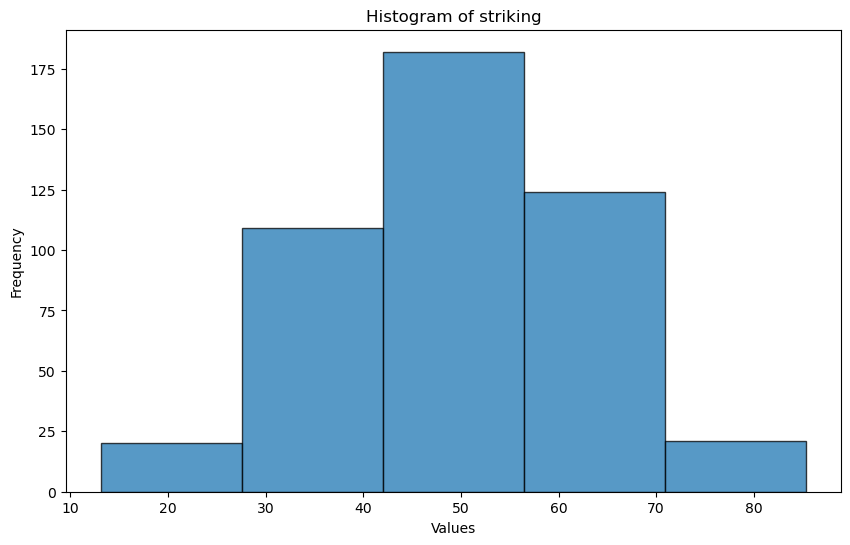

Skewness: -0.09, Distribution Type: Approximately Normal
Distribution of 'appealing/ funny' sentiment:
The distribution of 'appealing/ funny' is Right-Skewed (Skewness: 0.53)


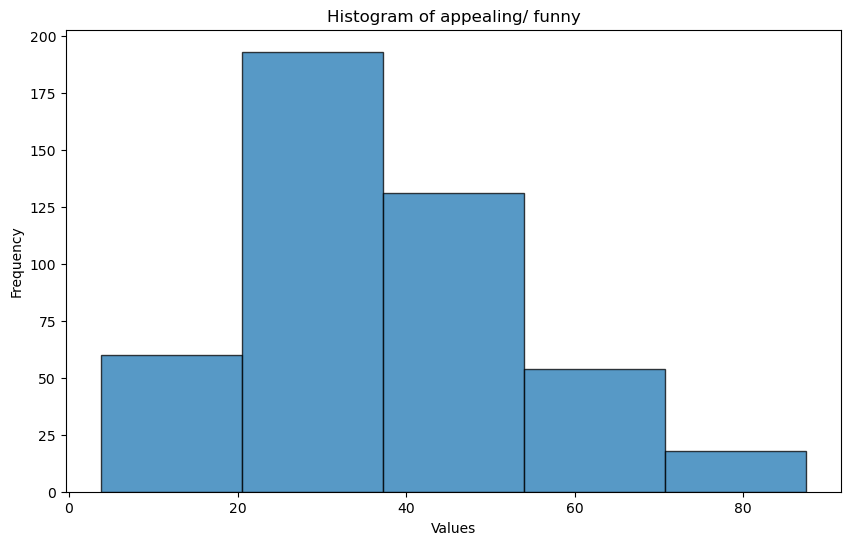

Skewness: 0.53, Distribution Type: Right-Skewed
Distribution of 'different' sentiment:
The distribution of 'different' is Approximately Normal (Skewness: 0.15)


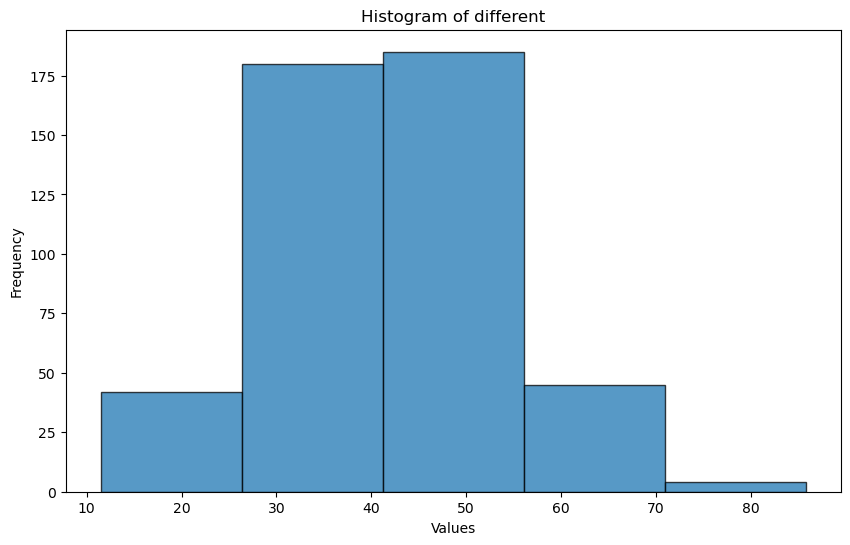

Skewness: 0.15, Distribution Type: Approximately Normal
Distribution of 'clear' sentiment:
The distribution of 'clear' is Approximately Normal (Skewness: -0.13)


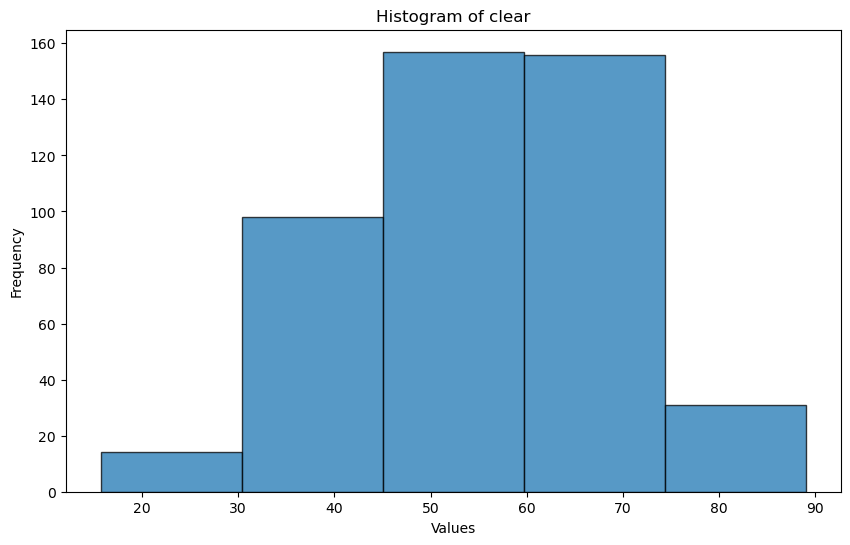

Skewness: -0.13, Distribution Type: Approximately Normal
Distribution of 'fits well' sentiment:
The distribution of 'fits well' is Approximately Normal (Skewness: -0.03)


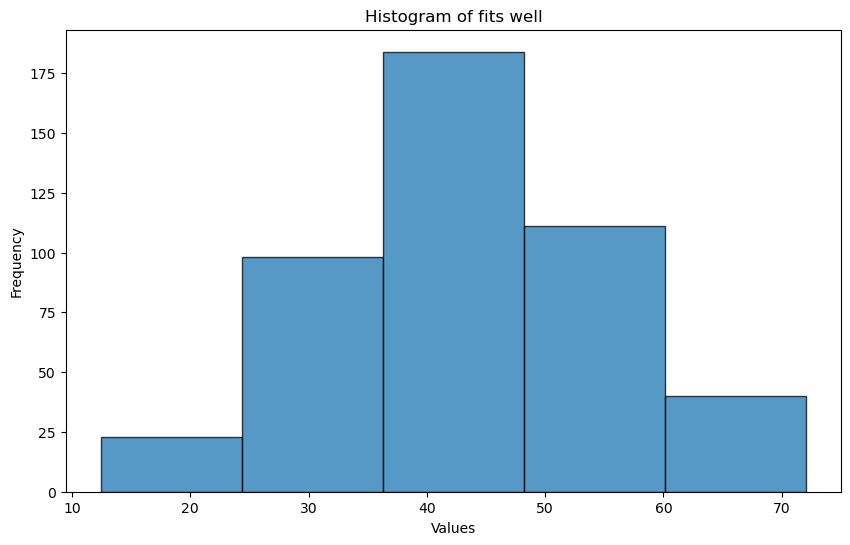

Skewness: -0.03, Distribution Type: Approximately Normal
Distribution of 'credible' sentiment:
The distribution of 'credible' is Approximately Normal (Skewness: 0.20)


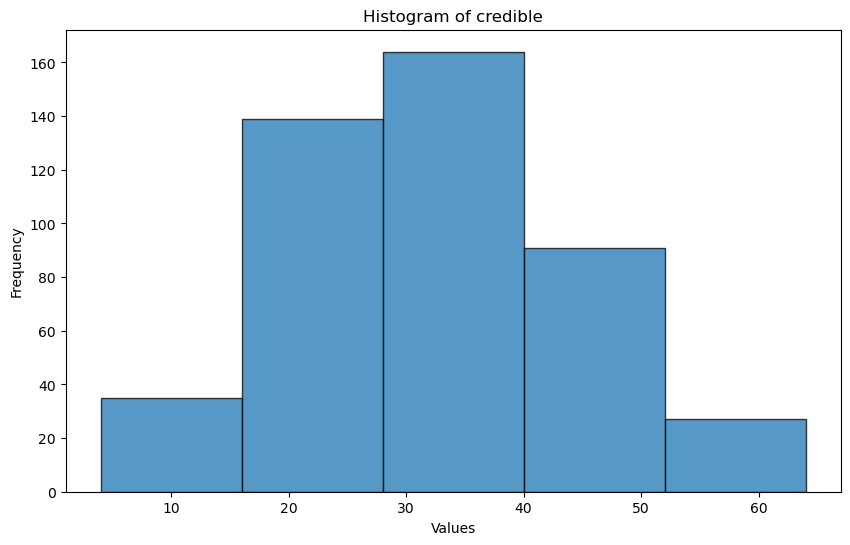

Skewness: 0.20, Distribution Type: Approximately Normal
Distribution of 'sympathetic' sentiment:
The distribution of 'sympathetic' is Approximately Normal (Skewness: 0.15)


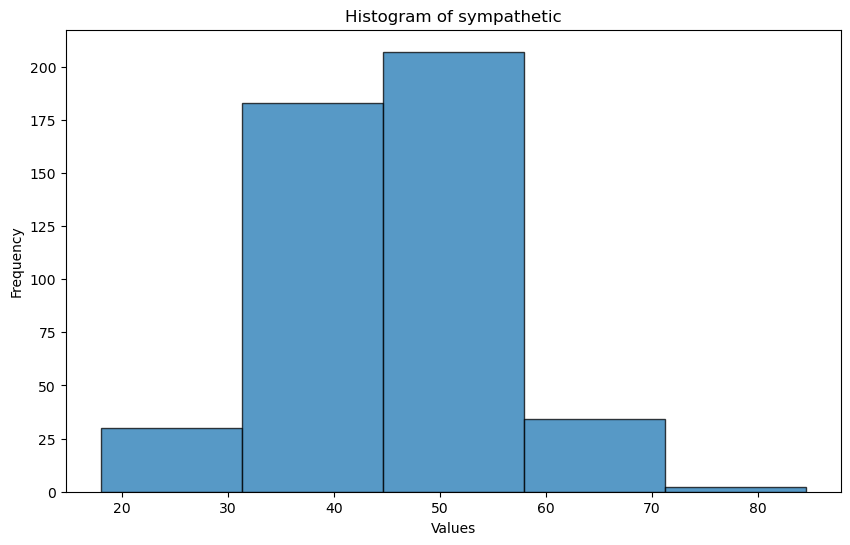

Skewness: 0.15, Distribution Type: Approximately Normal
Distribution of 'action' sentiment:
The distribution of 'action' is Right-Skewed (Skewness: 1.14)


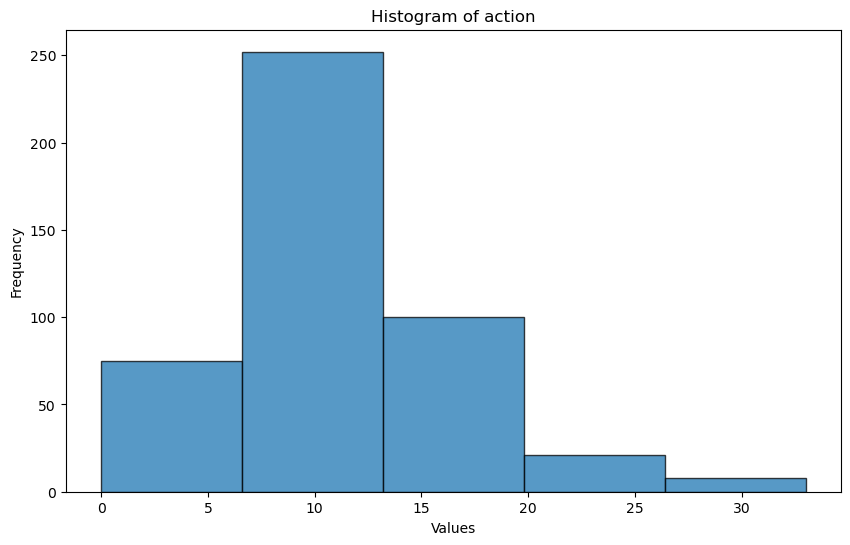

Skewness: 1.14, Distribution Type: Right-Skewed
Distribution of 'addresses me' sentiment:
The distribution of 'addresses me' is Right-Skewed (Skewness: 0.60)


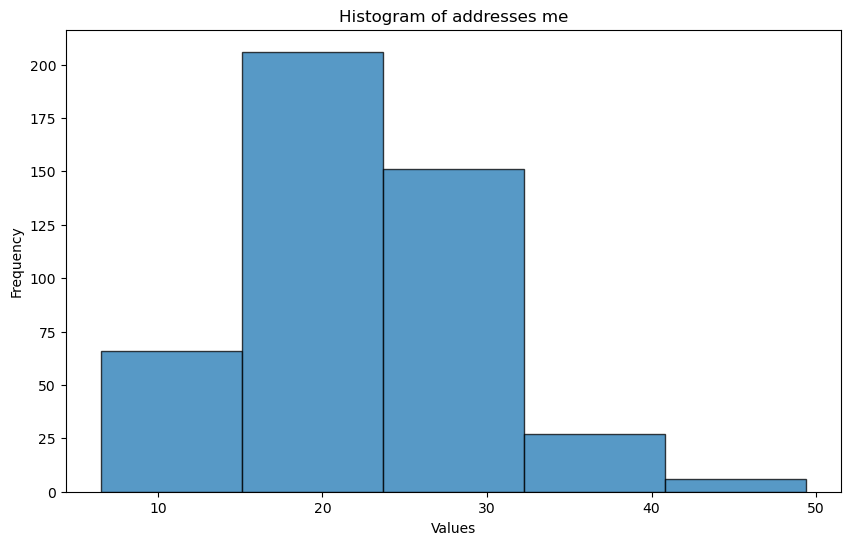

Skewness: 0.60, Distribution Type: Right-Skewed
Distribution of 'news' sentiment:
The distribution of 'news' is Right-Skewed (Skewness: 0.67)


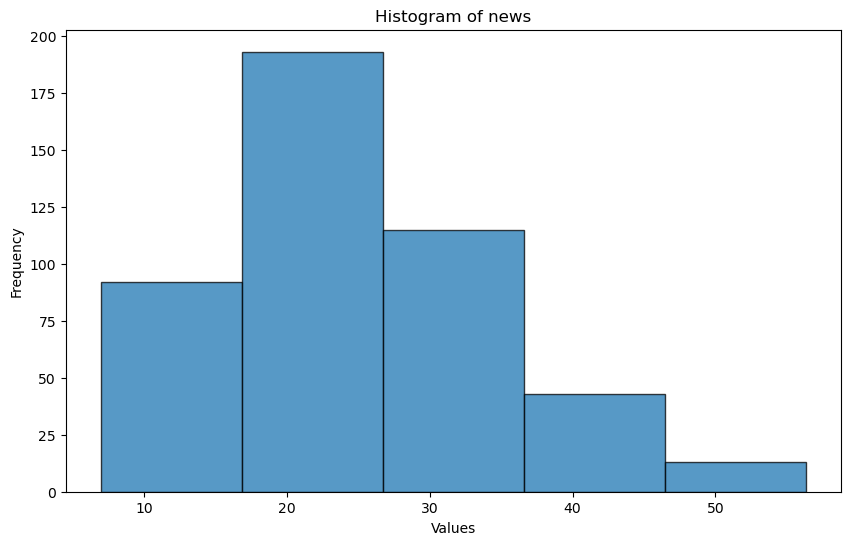

Skewness: 0.67, Distribution Type: Right-Skewed
Distribution of 'popularity' sentiment:
The distribution of 'popularity' is Approximately Normal (Skewness: -0.41)


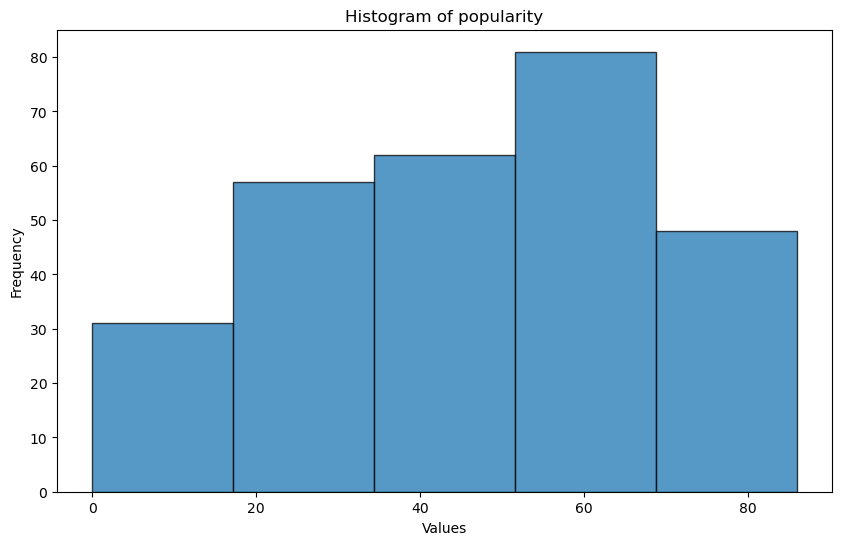

Skewness: -0.41, Distribution Type: Approximately Normal

Distribution Types for each column:
{'striking': 'Approximately Normal', 'appealing/ funny': 'Right-Skewed', 'different': 'Approximately Normal', 'clear': 'Approximately Normal', 'fits well': 'Approximately Normal', 'credible': 'Approximately Normal', 'sympathetic': 'Approximately Normal', 'action': 'Right-Skewed', 'addresses me': 'Right-Skewed', 'news': 'Right-Skewed', 'popularity': 'Approximately Normal'}


In [18]:
#Checking the distribution and skewness of each numerical column which has missing values for imputation

# Dictionary to store distribution types
distribution_dict = {}

for i in numeric_columns_withNulls:
    print(f"Distribution of '\033[1m{i}\033[0m' sentiment:")
    
    # Call the function with the current column name
    skewness, distribution_type = plot_histogram_and_check_distribution(
        data, 
        value_column=i,  # Correctly use the column name
        bins=5, 
        xlabel='Values'
    )
    
    # Print skewness and distribution type
    print(f"Skewness: {skewness:.2f}, Distribution Type: {distribution_type}")
    
    # Save the distribution type in the dictionary
    distribution_dict[i] = distribution_type

# Print the distribution dictionary
print("\nDistribution Types for each column:")
print(distribution_dict)


In [20]:
#Imputation of numerical columns based on their distribution type
#by mean for normally distributed, by median for skewed distribution

numerical_columns = list(distribution_dict.keys())
data = impute_numerical_columns_by_distribution(data, distribution_dict, numerical_columns)
#print(data.isnull().sum())


In [22]:
#Checking the categorical columns which have nulls
print("Categorical columns with missing values:")
Categorical_columns_withNulls=find_missing_columns(data, column_type='categorical')
print(Categorical_columns_withNulls)

Categorical columns with missing values:
['song_title', 'artist', 'genre']


#############################################################################################################################################

################################################### 2. Feature Engineering 

#############################################################################################################################################

In [29]:
#Impute the categorical column nulls with new category "NotPresent"
data=impute_categorical_columns_with_category(data, Categorical_columns_withNulls, missing_category="NotPresent")

In [31]:
#Encoding the categorical columns: Label encoding for binary categories and one hot encoding for multiple categories

label_encoding_columns=['background_music','dutch_spoken_language','dutch_voice_over', 'dutch_subtitles','music','recognized_music','family_in_commercial','children_in_commercial','animal_in_commercial','day_or_night']
one_hot_encoding_columns=['spot type','background_of_commercial']
data=label_encode_columns(data, label_encoding_columns)
data = apply_one_hot_encoding(data, one_hot_encoding_columns)

In [33]:
# Define the threshold for classification and create a new feature(will be used as dependent variable for classification)
#'recognition_label' based on threshold

threshold = data['recognition'].median()
# Create a new column 'recognition_label' with binary labels
data['recognition_label'] = data['recognition'].apply(lambda x: 1 if x >= threshold else 0)


In [35]:
#Dropping these columns
data=data.drop(columns=['recognition','brand','weeks','song_title', 'artist', 'genre'])

In [37]:
#Adding category prefixes to column names based on their specified categories for better understaning of columns

# Define column categories
Sentiments = ['striking', 'appealing/ funny', 'different', 'clear', 'fits well', 'credible', 'sympathetic', 'action', 'addresses me', 'news']
Marketing_data = ['grps', 'flight no.', 'cum. Grps', 'spotlength', 'spot type_billboard', 'spot type_regular spot', 'spot type_tagon']
Creative_features = ['popularity', 'background_music', 'dutch_spoken_language', 'dutch_voice_over', 'dutch_subtitles', 'car_being_shown (%)'
                     , 'car_brand_logo_visible (%)', 'family_in_commercial', 'children_in_commercial', 'animal_in_commercial',
                     'day_or_night', 'music', 'recognized_music','background_of_commercial_city','background_of_commercial_colored board','background_of_commercial_nature-like/rural area']

data = prefix_columns(data, Sentiments, Marketing_data, Creative_features)

# Print the renamed DataFrame columns
#print(data.columns)

#############################################################################################################################################

######################################## 3. Model Training, Evaluation and Feature importance 

#############################################################################################################################################

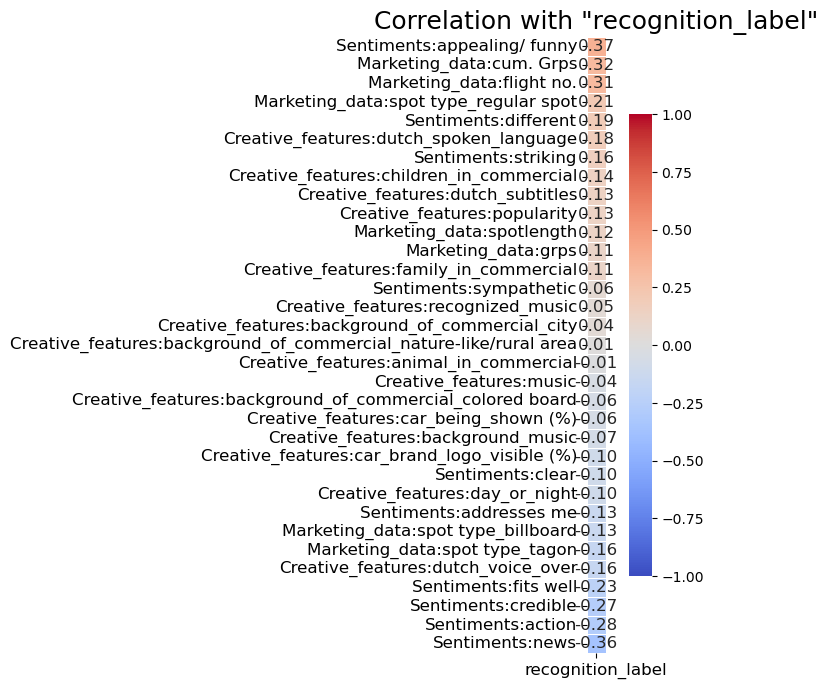

In [42]:
# Plot sorted correlations with the target column 'recognition_label'
plot_sorted_correlations(data, 'recognition_label')

In [44]:
# Training and evaluating Random forest classifier model
X = data.drop(['recognition_label'], axis=1)
y = data['recognition_label']
model, y_pred, X_train, X_test, y_train, y_test = train_and_evaluate(X, y)

              precision    recall  f1-score   support

           0       0.78      0.62      0.69        47
           1       0.69      0.84      0.76        49

    accuracy                           0.73        96
   macro avg       0.74      0.73      0.72        96
weighted avg       0.74      0.73      0.73        96

Accuracy: 0.7291666666666666


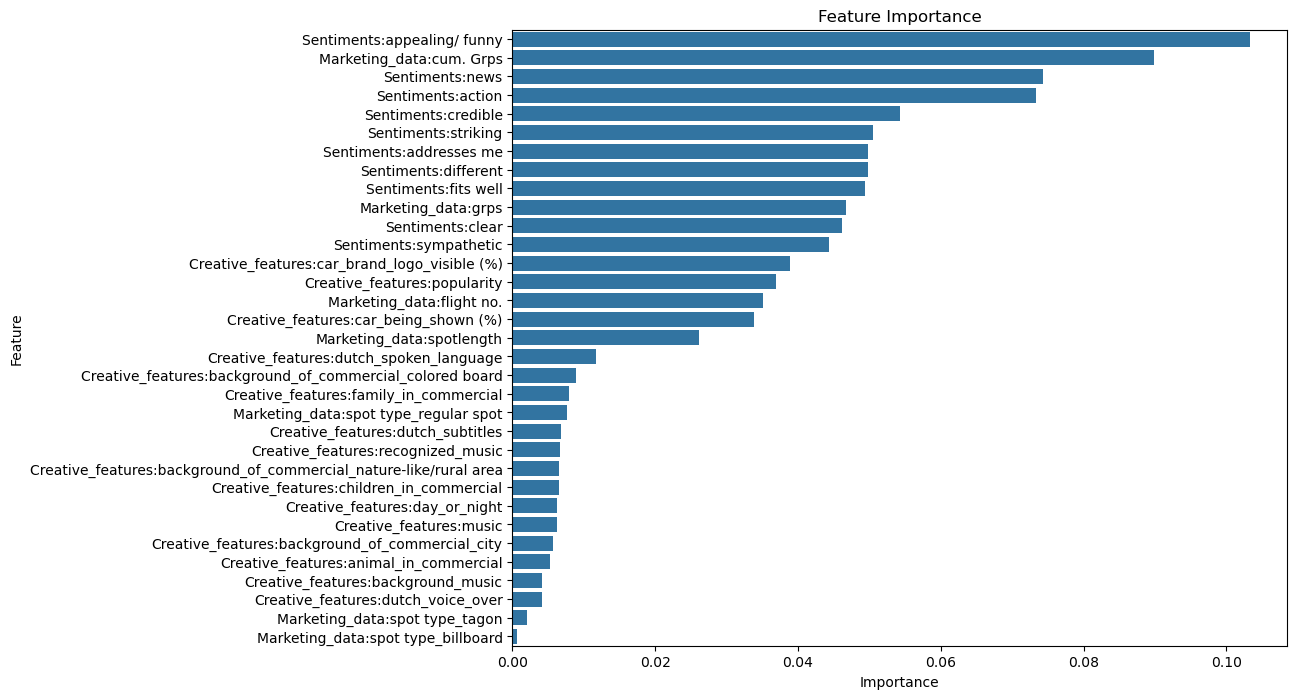

In [46]:
# Ploting feature importance
plot_feature_importance(model, X)